In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive')

Mounted at /content/drive


In [4]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")
# counts_pd.head()

In [5]:
counts_pd=counts_pd.drop(columns = ['Unnamed: 0'])
labels_pd=labels_pd.drop(columns = ['index'])


Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [6]:


X_train, X_test, y_train, y_test = train_test_split(counts_pd, labels_pd, test_size=0.2, random_state=0, shuffle=True)
X_train_np = X_train.values
X_test_np = X_test.values
# y_train_np = y_train.values
# y_test_np = y_test.values
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
# y_train= torch.tensor(y_train_np, dtype=torch.float32)
# y_test = torch.tensor(y_test_np, dtype=torch.float32)

Create a fully connected neural network for your autoencoder. Your latent space can be of any size less than or equal to 64. Too large may result in a poor visualization, and too small may result in high loss. 32 is a good starting point.

Consider using more than 1 hidden layer, and a sparcity constraint (l1 regularization).

Have an encoder model which is a model of only the layers for the encoding.

In [7]:
#ae, 1e-3, 300, l1=1.5e-5, l2=0
class autoencode(nn.Module):
    def __init__(self):
        super(autoencode, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(765, 300),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(300,300),
            nn.ReLU(),
            nn.Linear(300,64),
            # nn.Linear(64,2)

        )
        self.decoder = nn.Sequential(
          #  nn.Linear(2, 64),
           nn.Linear(64,300),
           nn.ReLU(),
           nn.Linear(300,300),
           nn.ReLU(),
           nn.Dropout(0.3),
           nn.Linear(300,765)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon

In [15]:
# no hidden layer __ ae, 1e-3, 300, l1=0, l2=5e-3
class autoencode(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(765, 32),
            nn.ReLU(),
            # nn.Dropout(0.7),
            # nn.Linear(300,64)

        )
        self.decoder = nn.Sequential(
          #  nn.Linear(64,300),
           nn.Linear(32,765),
           nn.ReLU(),
          #  nn.Dropout(0.7),
          #  nn.Linear(300,765)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon

In [29]:
# 2 hidden layers ... terrible __
class autoencode(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(765, 300),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(300,64),
            nn.ReLU(),
            nn.Linear(64,32)

        )
        self.decoder = nn.Sequential(
           nn.Linear(32,64),
           nn.ReLU(),
           nn.Linear(64,300),
           nn.ReLU(),
           nn.Dropout(0.7),
           nn.Linear(300,765)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon

In [375]:
#better 1 hidden layer __ ae, 1e-3, 300, l1=0, l2=5e-3
class autoencode(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(765, 300),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(300,32)

        )
        self.decoder = nn.Sequential(
           nn.Linear(32,300),
           nn.ReLU(),
           nn.Dropout(0.7),
           nn.Linear(300,765)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon

In [363]:
#funky 3 hidden layers
class autoencode(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(765, 500),
            # nn.Linear(765, 383),
            # nn.Tanh(),
            # nn.Dropout(0.1),
            # nn.Linear(383, 191),
            # nn.Tanh(),
            # nn.Dropout(0.1),
            # nn.Linear(191, 96),
            # nn.Tanh(),
            # nn.Linear(96, 48),
            # nn.Tanh(),
            # nn.Linear(48, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(500, 250),
            # nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(250, 125),
            # nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(125, 64),
            # nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            # nn.ReLU(),
            # nn.Linear(32, 16)
            # nn.Linear(500, 16)
        )
        self.decoder = nn.Sequential(
            # nn.Linear(16, 48),
            # nn.Tanh(),
            # nn.Linear(48, 96),
            # nn.Tanh(),
            # nn.Linear(96, 191),
            # nn.Tanh(),
            # nn.Dropout(0.1),
            # nn.Linear(191, 383),
            # nn.Tanh(),
            # nn.Dropout(0.1),
            # nn.Linear(383, 765),
            # nn.Linear(16, 500),
            # nn.Linear(16, 32),
            # nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 125),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(125, 250),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(500, 765),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon

In [9]:
class AETrainer:

    def __init__(self, model, learning_rate, epoch, l1, l2):
        self.model = model
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")

        self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        self.l1 = l1
        self.epoch = epoch
        # self.batch_size = batch_size
        self.loss_func= nn.MSELoss()


    def train(self, X_train, X_test, early_stop=True, verbose=True, draw_curve=True):

        train_loss_list = []
        val_loss_list = []

        weights = self.model.state_dict()
        lowest_val_loss = np.inf

        for n in tqdm(range(self.epoch), leave=False):
            self.model.train()
            epoch_loss = 0.0
            # batch_importance = 1 / len(X_train)
            # call the model
            l1_reg = 0
            for param in self.model.parameters():
                l1_reg += torch.sum(torch.abs(param))
            # print(self.model.parameters)
            # print(l1_reg,":",l1_reg * self.l1 )
            _, X_train_recon = self.model(X_train) #forward pass
            train_loss = self.loss_func(X_train_recon, X_train) + (l1_reg * self.l1)#

            self.optimizer.zero_grad()
            train_loss.backward()
            self.optimizer.step()


            epoch_loss += train_loss.detach().cpu().item() #* batch_importance

            train_loss_list.append(epoch_loss)

            val_loss = self.evaluate(X_test, print_loss=False)
            val_loss_list.append(val_loss)

            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    # best_epoch = n
                    weights = self.model.state_dict()

        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(x_axis, train_loss_list, label="Train")
            ax.plot(x_axis, val_loss_list, label="Validation")
            ax.set_title("Total Loss")
            ax.set_xlabel("# Epoch")

        if early_stop:
            torch.save(weights, 'autoencoder_model.pth')
            self.model.load_state_dict(weights)

        return {
            # "train_loss_list": train_loss_list,
            # "val_loss_list": val_loss_list,
        }

    def evaluate(self, X_test, print_loss=True):
        self.model.eval()
        total_loss = 0.0
        with torch.no_grad():
            # batch_importance = 1 / len(X_test)
            _, X_val_recon= self.model(X_test) #foward pass
            loss = self.loss_func(X_val_recon, X_test)
            total_loss = loss.detach().cpu().item() #* batch_importance
        if print_loss:
            print(f"Total Loss: {total_loss}")
        return total_loss

Train your autoencoding using MSE loss.

Finally, identify the parameters which don't overfit, and use the same model architecture and train on all of the data together.

With a latent space size of 32, aim for 0.9 MSE loss on your test set, 0.95 with regularization. You will not be graded strictly on a loss cutoff.

autoencode - Number of parameters: 503021


{}

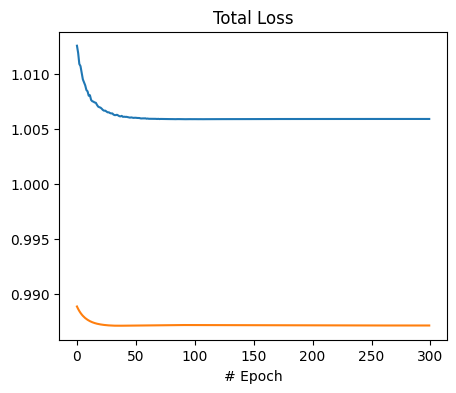

In [30]:
ae= autoencode()
# AE = Autoencoder()
#model, learning_rate, batch_size, epoch, l2
train= AETrainer(ae, 1e-3, 300, l1=0, l2=5e-3)

train.train(X_train, X_test)

In [31]:
ae= autoencode()
state_dict = torch.load('autoencoder_model.pth')
ae.load_state_dict(state_dict)
ae.eval()
with torch.no_grad():
    z, _ = ae(torch.Tensor(counts_pd.values))

In [32]:


pca = PCA(n_components=2)
X_pca = pca.fit_transform(counts_pd, labels_pd)
# cmap = plt.cm.get_cmap('viridis')
X_tsne = TSNE(n_components=2, learning_rate='auto',
                ).fit_transform(counts_pd, labels_pd)


z_pca = pca.fit_transform(z, labels_pd)
z_tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(z, labels_pd)


Use PCA and t-SNE on the dataset.

Then use PCA on the latent space representation of the dataset.

Plot all of these.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


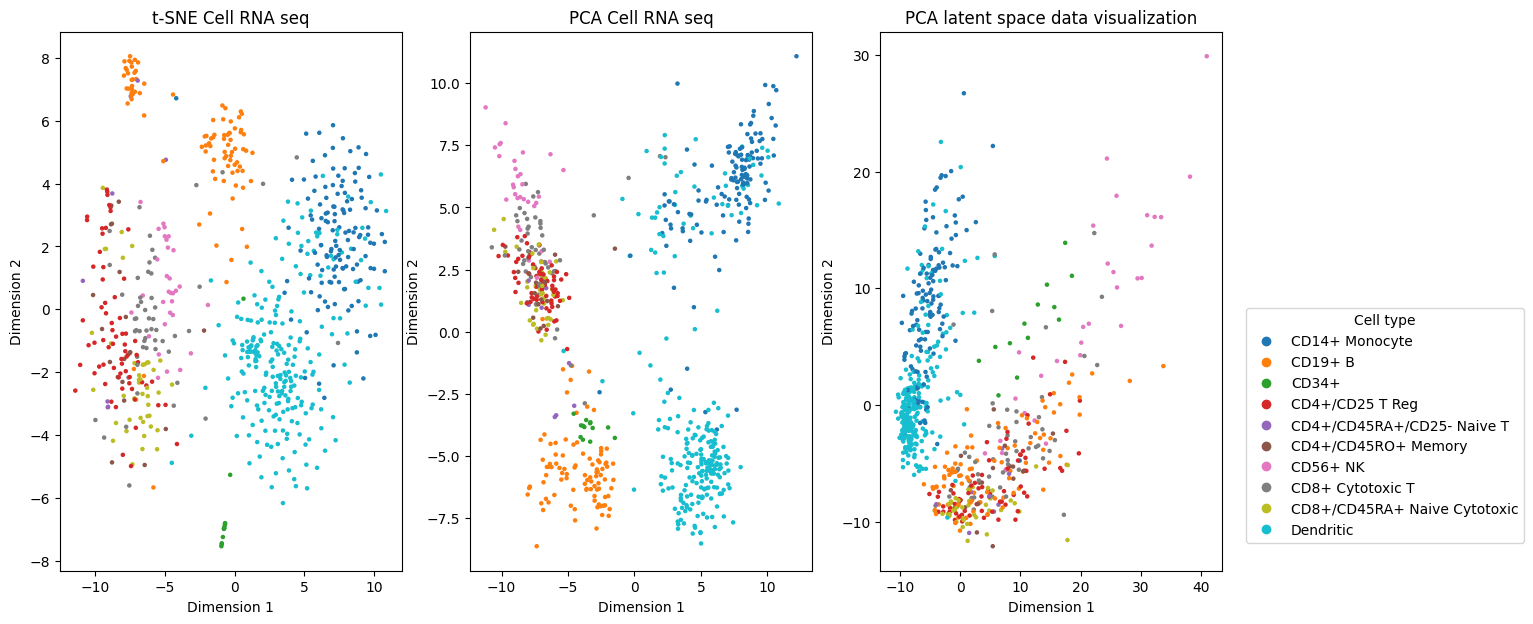

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
numeric_labels = le.fit_transform(labels_pd)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

cmap = plt.get_cmap('tab10')


ax1.scatter(X_tsne[:, 0], X_tsne[:,1], c=numeric_labels, cmap=cmap, s=5)
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")
ax1.set_title("t-SNE Cell RNA seq")
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:,1], c=numeric_labels, cmap=cmap, s=5)
ax2.set_xlabel("Dimension 1")
ax2.set_ylabel("Dimension 2")
ax2.set_title("PCA Cell RNA seq")
scatter3 = ax3.scatter(z_pca[:, 0], z_pca[:,1], c=numeric_labels, cmap=cmap, s=5)
ax3.set_xlabel("Dimension 1")
ax3.set_ylabel("Dimension 2")
ax3.set_title("PCA latent space data visualization")
legend_elements2,_ = scatter2.legend_elements()
# ax2.legend(*legend_elements2,le.inverse_transform(range(len(le.classes_))), title="Cell type")
plt.legend(legend_elements2, le.inverse_transform(range(len(le.classes_))), title="Cell type", bbox_to_anchor=(1.05, 0.5))

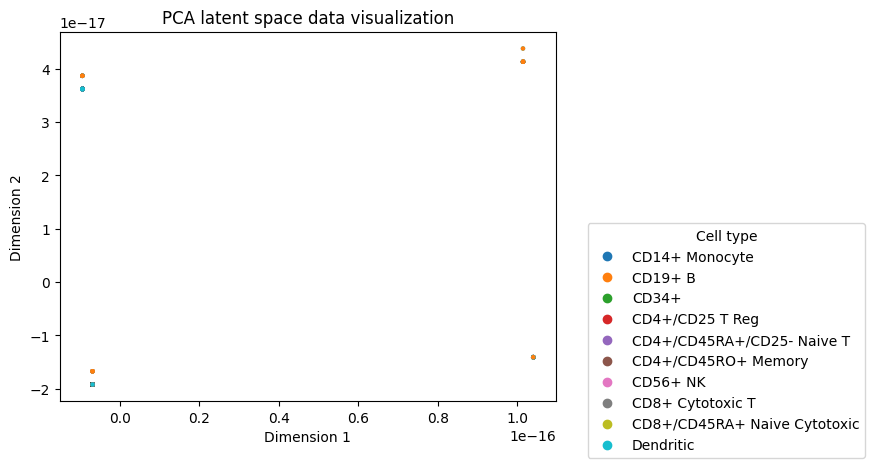

In [33]:
scatter3 = plt.scatter(z_pca[:, 0], z_pca[:,1], c=numeric_labels, cmap=cmap, s=5)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("PCA latent space data visualization")
legend_elements3,_ = scatter3.legend_elements()
plt.legend(legend_elements3, le.inverse_transform(range(len(le.classes_))), title="Cell type", bbox_to_anchor=(1.05, 0.5))

Compare the results of PCA, t-SNE, and your autoencoder as ways to visualize the data.